In [1]:
import numpy as np
import pandas as pd

# import sqlite3
# conn = sqlite3.connect('movie_db.sqlite')
# cur = conn.cursor()

from pandasql import sqldf

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [2]:
#load individual files to individual dataframes
tmdb_movies = pd.DataFrame(pd.read_csv('./zippedData/tmdb.movies.csv'))
imdb_crew = pd.DataFrame(pd.read_csv('./zippedData/imdb.title.crew.csv'))
tn_budgets = pd.DataFrame(pd.read_csv('./zippedData/tn.movie_budgets.csv'))
imdb_ratings = pd.DataFrame(pd.read_csv('./zippedData/imdb.title.ratings.csv'))
imdb_name_basics = pd.DataFrame(pd.read_csv('./zippedData/imdb.name.basics.csv'))
imdb_principals = pd.DataFrame(pd.read_csv('./zippedData/imdb.title.principals.csv'))
imdb_akas = pd.DataFrame(pd.read_csv('./zippedData/imdb.title.akas.csv'))
bom_gross = pd.DataFrame(pd.read_csv('./zippedData/bom.movie_gross.csv'))
imdb_title_basics = pd.DataFrame(pd.read_csv('./zippedData/imdb.title.basics.csv'))

In [3]:
#list of dataframes to iterate over
db_list = [tmdb_movies, imdb_crew, tn_budgets, imdb_ratings, imdb_name_basics, 
           imdb_principals, imdb_akas, bom_gross, imdb_title_basics,]

#get name and info for each dataframe in db_list
def db_check(data):
    for db in data:
        name =[x for x in globals() if globals()[x] is db][0]
        print("File %s" % name)
        print(db.info())
        print('\n')

db_check(db_list)

#above function returns the same results as below
# print(tmbd_movies.info())
# print('\n')
# print(imdb_crew.info())
# print('\n')
# print(tn_budgets.info())
# print('\n')
# print(imdb_ratings.info())
# print('\n')
# print(imdb_name_basics.info()) 
# print('\n')
# print(imdb_principals.info())
# print('\n')
# print(bom_gross.info())
# print('\n')
# print(imdb_title_basics.info())
# print('\n')

File tmdb_movies
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
Unnamed: 0           26517 non-null int64
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB
None


File imdb_crew
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
tconst       146144 non-null object
directors    140417 non-null object
writers      110261 non-null object
dtypes: object(3)
memory usage: 3.3+ MB
None


File tn_budgets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data c

In [4]:
#rename similar title identification columns for cleaner joins

imdb_crew = imdb_crew.rename({'tconst': 'title_id'}, axis=1)
imdb_ratings = imdb_ratings.rename({'tconst': 'title_id'}, axis=1)
imdb_principals = imdb_principals.rename({'tconst': 'title_id'}, axis=1)
imdb_title_basics = imdb_title_basics.rename({'tconst': 'title_id'}, axis=1)
imdb_name_basics = imdb_name_basics.rename({'nconst': 'crew_id'}, axis=1)

In [5]:
tn_budgets.production_budget = tn_budgets.production_budget.apply(lambda x: x.strip('$').replace(',',''))
tn_budgets.worldwide_gross = tn_budgets.worldwide_gross.apply(lambda x: x.strip('$').replace(',',''))

In [6]:
tn_budgets.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [7]:
tn_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747


In [8]:
tn_budgets[['production_budget', 'worldwide_gross']] = tn_budgets[['production_budget', 'worldwide_gross']].apply(pd.to_numeric)

In [9]:
tn_budgets.dtypes

id                    int64
release_date         object
movie                object
production_budget     int64
domestic_gross       object
worldwide_gross       int64
dtype: object

In [10]:
tn_budgets.eval("total_profit = worldwide_gross - production_budget", inplace=True)

In [11]:
tn_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747,999721747


In [12]:
tn_budgets = tn_budgets.sort_values(['total_profit'], ascending=False)

In [13]:
tn_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279,2351345279
42,43,"Dec 19, 1997",Titanic,200000000,"$659,363,944",2208208395,2008208395
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,"$678,815,482",2048134200,1748134200
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,"$936,662,225",2053311220,1747311220
33,34,"Jun 12, 2015",Jurassic World,215000000,"$652,270,625",1648854864,1433854864


In [14]:
tn_budgets.set_index('movie').head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,total_profit
movie,,,,,,
Avatar,1,"Dec 18, 2009",425000000,"$760,507,625",2776345279,2351345279
Titanic,43,"Dec 19, 1997",200000000,"$659,363,944",2208208395,2008208395
Avengers: Infinity War,7,"Apr 27, 2018",300000000,"$678,815,482",2048134200,1748134200
Star Wars Ep. VII: The Force Awakens,6,"Dec 18, 2015",306000000,"$936,662,225",2053311220,1747311220
Jurassic World,34,"Jun 12, 2015",215000000,"$652,270,625",1648854864,1433854864


In [15]:
imdb_title_basics.head()

,title_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [16]:
primary_title = imdb_title_basics.set_index('primary_title')

In [17]:
primary_title.head()

,title_id,original_title,start_year,runtime_minutes,genres
primary_title,,,,,
Sunghursh,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
One Day Before the Rainy Season,tt0066787,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
The Other Side of the Wind,tt0069049,The Other Side of the Wind,2018,122.0,Drama
Sabse Bada Sukh,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
The Wandering Soap Opera,tt0100275,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [18]:
tn_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 0 to 2
Data columns (total 7 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null int64
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null int64
total_profit         5782 non-null int64
dtypes: int64(4), object(3)
memory usage: 361.4+ KB


In [19]:
top_movies = tn_budgets.join(primary_title, how = 'outer', rsuffix = '_alt')

In [20]:
top_movies.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit,title_id,original_title,start_year,runtime_minutes,genres
0,1.0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,2.351345e+09,NaN,NaN,NaN,NaN,NaN
1,2.0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,"$241,063,875",1.045664e+09,6.350639e+08,NaN,NaN,NaN,NaN,NaN
2,3.0,"Jun 7, 2019",Dark Phoenix,350000000.0,"$42,762,350",1.497624e+08,-2.002376e+08,NaN,NaN,NaN,NaN,NaN
3,4.0,"May 1, 2015",Avengers: Age of Ultron,330600000.0,"$459,005,868",1.403014e+09,1.072414e+09,NaN,NaN,NaN,NaN,NaN
4,5.0,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,"$620,181,382",1.316722e+09,9.997217e+08,NaN,NaN,NaN,NaN,NaN


In [21]:
top_movies.sort_values(['total_profit'], ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit,title_id,original_title,start_year,runtime_minutes,genres
0,1.0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,2.351345e+09,NaN,NaN,NaN,NaN,NaN
42,43.0,"Dec 19, 1997",Titanic,200000000.0,"$659,363,944",2.208208e+09,2.008208e+09,NaN,NaN,NaN,NaN,NaN
6,7.0,"Apr 27, 2018",Avengers: Infinity War,300000000.0,"$678,815,482",2.048134e+09,1.748134e+09,NaN,NaN,NaN,NaN,NaN
5,6.0,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,"$936,662,225",2.053311e+09,1.747311e+09,NaN,NaN,NaN,NaN,NaN
33,34.0,"Jun 12, 2015",Jurassic World,215000000.0,"$652,270,625",1.648855e+09,1.433855e+09,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
è solo questione di punti di vista,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt3566826,è solo questione di punti di vista,2012.0,103.0,"Action,Adventure,Comedy"
è solo questione di tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt3547074,è solo questione di tempo,2013.0,72.0,Comedy
élèctions piege à cons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt8976950,élèctions piege à cons,2014.0,NaN,Comedy
împetu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt5997078,împetu,2017.0,NaN,Documentary


In [22]:
top_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151926 entries, 0 to Šiška Deluxe
Data columns (total 12 columns):
id                   5782 non-null float64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null float64
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null float64
total_profit         5782 non-null float64
title_id             146144 non-null object
original_title       146123 non-null object
start_year           146144 non-null float64
runtime_minutes      114405 non-null float64
genres               140736 non-null object
dtypes: float64(6), object(6)
memory usage: 15.1+ MB


In [23]:
top_movies.drop(columns = 'id')

,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit,title_id,original_title,start_year,runtime_minutes,genres
0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,2.351345e+09,NaN,NaN,NaN,NaN,NaN
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,"$241,063,875",1.045664e+09,6.350639e+08,NaN,NaN,NaN,NaN,NaN
2,"Jun 7, 2019",Dark Phoenix,350000000.0,"$42,762,350",1.497624e+08,-2.002376e+08,NaN,NaN,NaN,NaN,NaN
3,"May 1, 2015",Avengers: Age of Ultron,330600000.0,"$459,005,868",1.403014e+09,1.072414e+09,NaN,NaN,NaN,NaN,NaN
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,"$620,181,382",1.316722e+09,9.997217e+08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
è solo questione di punti di vista,NaN,NaN,NaN,NaN,NaN,NaN,tt3566826,è solo questione di punti di vista,2012.0,103.0,"Action,Adventure,Comedy"
è solo questione di tempo,NaN,NaN,NaN,NaN,NaN,NaN,tt3547074,è solo questione di tempo,2013.0,72.0,Comedy
élèctions piege à cons,NaN,NaN,NaN,NaN,NaN,NaN,tt8976950,élèctions piege à cons,2014.0,NaN,Comedy
împetu,NaN,NaN,NaN,NaN,NaN,NaN,tt5997078,împetu,2017.0,NaN,Documentary


In [24]:
top_movies = top_movies.sort_values(['total_profit'], ascending=False).drop(columns = 'id')

In [25]:
top_movies.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit,title_id,original_title,start_year,runtime_minutes,genres
0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,2.351345e+09,NaN,NaN,NaN,NaN,NaN
42,"Dec 19, 1997",Titanic,200000000.0,"$659,363,944",2.208208e+09,2.008208e+09,NaN,NaN,NaN,NaN,NaN
6,"Apr 27, 2018",Avengers: Infinity War,300000000.0,"$678,815,482",2.048134e+09,1.748134e+09,NaN,NaN,NaN,NaN,NaN
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,"$936,662,225",2.053311e+09,1.747311e+09,NaN,NaN,NaN,NaN,NaN
33,"Jun 12, 2015",Jurassic World,215000000.0,"$652,270,625",1.648855e+09,1.433855e+09,NaN,NaN,NaN,NaN,NaN


In [26]:
# q = """ SELECT
#         top.total_profit, top.release_date, top.runtime_minutes, top.title_id
#         FROM top_movies top
#         JOIN imdb_akas aka
#         ON top.title_id = aka.title_id
#         WHERE title_id == True
#         ORDER BY total_profit DESC
#         LIMIT 50
#         """

def make_top_rel(data):
    for col in data.columns:
        if col == 'total_profit':
            pass
        elif col =='release_date': 
            pass
        elif col =='movie':
            pass
        else:
            del data[col]
            
make_top_rel(top_movies)

In [27]:
top_movies.head()

,release_date,movie,total_profit
0,"Dec 18, 2009",Avatar,2.351345e+09
42,"Dec 19, 1997",Titanic,2.008208e+09
6,"Apr 27, 2018",Avengers: Infinity War,1.748134e+09
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,1.747311e+09
33,"Jun 12, 2015",Jurassic World,1.433855e+09


In [28]:
top_movies = top_movies.iloc[:578]

In [29]:
top_movies

,release_date,movie,total_profit
0,"Dec 18, 2009",Avatar,2.351345e+09
42,"Dec 19, 1997",Titanic,2.008208e+09
6,"Apr 27, 2018",Avengers: Infinity War,1.748134e+09
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,1.747311e+09
33,"Jun 12, 2015",Jurassic World,1.433855e+09
...,...,...,...
185,"Nov 21, 2008",Bolt,1.780150e+08
1633,"Jul 8, 2011",Horrible Bosses,1.774176e+08
3537,"Oct 22, 2004",The Grudge,1.772811e+08
2718,"Dec 1, 2017",The Shape of Water,1.762908e+08


In [30]:
top_movies.describe()

,total_profit
count,5.780000e+02
mean,4.007630e+08
std,2.583152e+08
min,1.760000e+08
25%,2.304424e+08
50%,3.049420e+08
75%,4.888554e+08
max,2.351345e+09


In [31]:
above_mean_profit = top_movies.drop(top_movies[top_movies.total_profit <
                                               top_movies.total_profit.mean()].index)


In [32]:
above_mean_profit.set_index('movie')

,release_date,total_profit
movie,,
Avatar,"Dec 18, 2009",2.351345e+09
Titanic,"Dec 19, 1997",2.008208e+09
Avengers: Infinity War,"Apr 27, 2018",1.748134e+09
Star Wars Ep. VII: The Force Awakens,"Dec 18, 2015",1.747311e+09
Jurassic World,"Jun 12, 2015",1.433855e+09
...,...,...
Sherlock Holmes,"Dec 25, 2009",4.084382e+08
Twister,"May 10, 1996",4.077000e+08
La La Land,"Dec 9, 2016",4.063512e+08


In [33]:
top_50_percent_profit = top_movies.drop(top_movies[top_movies.total_profit < 
                                                   top_movies.total_profit.quantile(.5)].index)

In [34]:
top_50_percent_profit.set_index('movie')

,release_date,total_profit
movie,,
Avatar,"Dec 18, 2009",2.351345e+09
Titanic,"Dec 19, 1997",2.008208e+09
Avengers: Infinity War,"Apr 27, 2018",1.748134e+09
Star Wars Ep. VII: The Force Awakens,"Dec 18, 2015",1.747311e+09
Jurassic World,"Jun 12, 2015",1.433855e+09
...,...,...
Rampage,"Apr 13, 2018",3.080563e+08
Alvin and the Chipmunks,"Dec 14, 2007",3.076050e+08
Gone Girl,"Oct 3, 2014",3.075672e+08


In [35]:
# top_50_percent_profit['release_date'] = pd.to_datetime(top_50_percent_profit['release_date'])

def str_dt(data):
    data['release_date'] = pd.to_datetime(data['release_date'])
    
str_dt(top_50_percent_profit)
str_dt(above_mean_profit)
str_dt(top_movies)

In [36]:
top_50_percent_profit.head()

,release_date,movie,total_profit
0,2009-12-18,Avatar,2.351345e+09
42,1997-12-19,Titanic,2.008208e+09
6,2018-04-27,Avengers: Infinity War,1.748134e+09
5,2015-12-18,Star Wars Ep. VII: The Force Awakens,1.747311e+09
33,2015-06-12,Jurassic World,1.433855e+09


In [37]:
# above_mean_profit['release_date'] = pd.to_datetime(above_mean_profit['release_date'])
# above_mean_profit = above_mean_profit.sort_values(by='release_date', ascending=True)
# above_mean_profit.set_index('movie')

In [38]:
above_mean_profit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 536
Data columns (total 3 columns):
release_date    196 non-null datetime64[ns]
movie           196 non-null object
total_profit    196 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.1+ KB


In [39]:
# timeframe_map = {above_mean_profit.release_date.between_time('1990-01-01','1999-12-31)'):'90\'s', above_mean_profit.release_date.between_time('2000-01-01','2009-12-31)'):'00\'s', 
#                  above_mean_profit.release_date.between_time('2010-01-01','2019-12-31)'):'10\'s'}
# # Add a new column 'is_weekend' that maps the 'day_of_week' column using weekend_map
# above_mean_profit.decade.astype('datetime64[ns]') = above_mean_profit.release_date.map(timeframe_map)
# decade = above_mean_profit.groupby('decade').sum()
# above_mean_profit['year'] = above_mean_profit['release_date'].dt.year
# above_mean_profit['year'] = pd.to_numeric(above_mean_profit['year'])
def to_decade(data):
    data['years'] = data['release_date'].dt.year
    data['decade'] = data.years.map(lambda x: (x//10)*10)
    
to_decade(above_mean_profit)
to_decade(top_50_percent_profit)
to_decade(top_movies)

In [40]:
above_mean_profit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 536
Data columns (total 5 columns):
release_date    196 non-null datetime64[ns]
movie           196 non-null object
total_profit    196 non-null float64
years           196 non-null int64
decade          196 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 9.2+ KB


In [41]:
top_50_percent_profit

,release_date,movie,total_profit,years,decade
0,2009-12-18,Avatar,2.351345e+09,2009,2000
42,1997-12-19,Titanic,2.008208e+09,1997,1990
6,2018-04-27,Avengers: Infinity War,1.748134e+09,2018,2010
5,2015-12-18,Star Wars Ep. VII: The Force Awakens,1.747311e+09,2015,2010
33,2015-06-12,Jurassic World,1.433855e+09,2015,2010
...,...,...,...,...,...
289,2018-04-13,Rampage,3.080563e+08,2018,2010
982,2007-12-14,Alvin and the Chipmunks,3.076050e+08,2007,2000
835,2014-10-03,Gone Girl,3.075672e+08,2014,2010
3172,1987-09-18,Fatal Attraction,3.061000e+08,1987,1980


In [42]:
above_mean_profit

,release_date,movie,total_profit,years,decade
0,2009-12-18,Avatar,2.351345e+09,2009,2000
42,1997-12-19,Titanic,2.008208e+09,1997,1990
6,2018-04-27,Avengers: Infinity War,1.748134e+09,2018,2010
5,2015-12-18,Star Wars Ep. VII: The Force Awakens,1.747311e+09,2015,2010
33,2015-06-12,Jurassic World,1.433855e+09,2015,2010
...,...,...,...,...,...
441,2009-12-25,Sherlock Holmes,4.084382e+08,2009,2000
481,1996-05-10,Twister,4.077000e+08,1996,1990
2491,2016-12-09,La La Land,4.063512e+08,2016,2010
2724,1990-11-09,Dances with Wolves,4.052000e+08,1990,1990


In [43]:
above_mean_profit.decade.value_counts()

2010    114
2000     54
1990     21
1980      4
1970      3
Name: decade, dtype: int64

In [44]:
top_50_percent_profit.decade.value_counts()

2010    156
2000     80
1990     35
1980     12
1970      5
1930      1
Name: decade, dtype: int64

In [45]:
def sort_list(data):
    data = data.sort_values(by='release_date', ascending=True, inplace=True)

sort_list(top_50_percent_profit)
sort_list(above_mean_profit)

In [46]:
above_mean_profit.groupby('decade').median()
top_movies.describe()

,total_profit,years,decade
count,5.780000e+02,578.000000,578.000000
mean,4.007630e+08,2006.058824,2001.262976
std,2.583152e+08,11.164284,11.215398
min,1.760000e+08,1937.000000,1930.000000
25%,2.304424e+08,2000.000000,2000.000000
50%,3.049420e+08,2009.000000,2000.000000
75%,4.888554e+08,2014.000000,2010.000000
max,2.351345e+09,2019.000000,2010.000000


In [47]:
def plot_decade_df(df, label):
    plt.figure(figsize=(15,8))
    plt.title(label)
    if 'top_movies':
        sns.set_style('darkgrid')
        plot1 = sns.regplot(x="decade", y="total_profit", data=df);
        plt.xlabel('Decades')
        plt.ylabel('Profit in Millions')
    elif 'top_50_percent_profit':
        sns.set_style('darkgrid')
        plot2 = sns.regplot(x="decade", y="total_profit", data=df);
        plt.xlabel('Decades')
        plt.ylabel('Profit in Millions')
    else:
        sns.set_style('darkgrid')
        plot3 = sns.regplot(x="decade", y="total_profit", data=df);
        plt.xlabel('Decades')
        plt.ylabel('Profit in Millions')

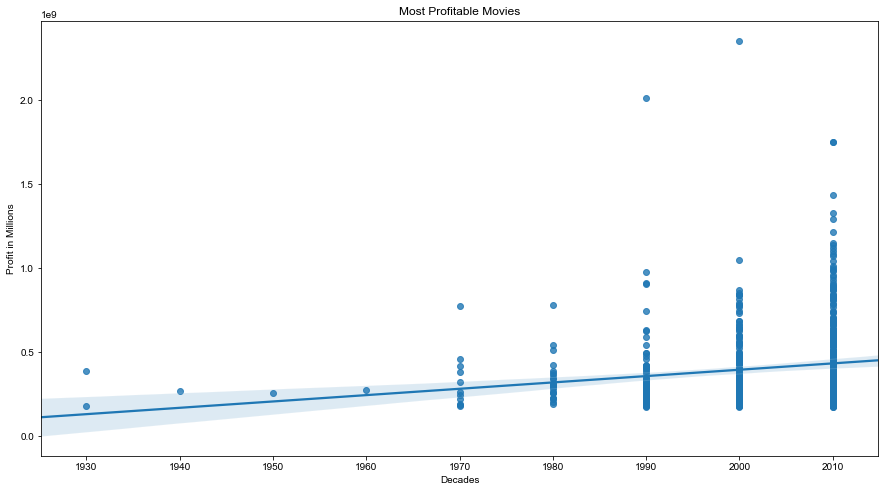

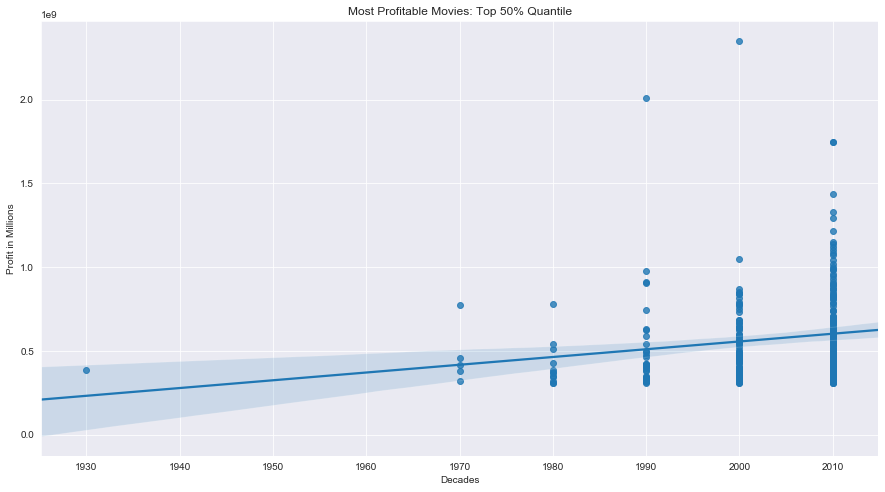

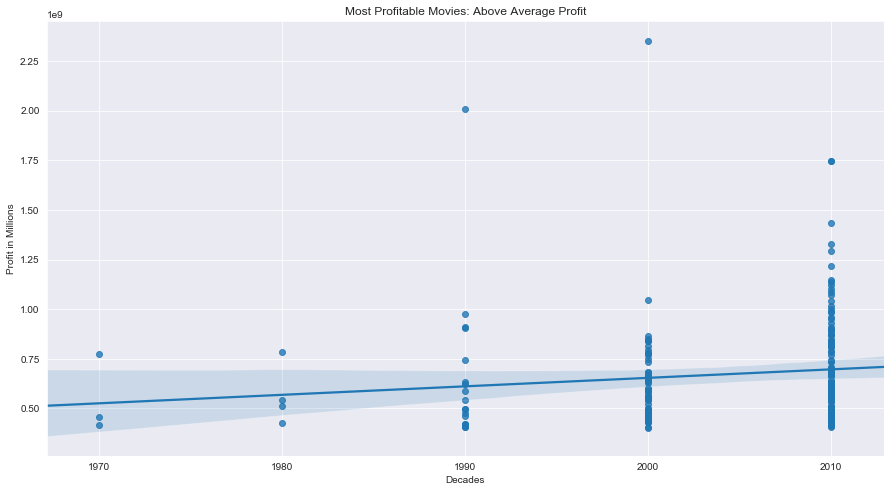

In [48]:
plot_decade_df(top_movies, 'Most Profitable Movies')
plot_decade_df(top_50_percent_profit, 'Most Profitable Movies: Top 50% Quantile')
plot_decade_df(above_mean_profit, 'Most Profitable Movies: Above Average Profit')

In [49]:
def plot_years_df(df, label):
    plt.figure(figsize=(15,8))
    plt.title(label)
    if 'top_movies':
        sns.set_style('darkgrid')
        sns.regplot(x="years", y="total_profit", data=df);
        plt.xlabel('Years')
        plt.ylabel('Profit in Millions')
    elif 'top_50_percent_profit':
        sns.set_style('darkgrid')
        sns.regplot(x="years", y="total_profit", data=df);
        plt.xlabel('Years')
        plt.ylabel('Profit in Millions')
    else:
        sns.set_style('darkgrid')
        sns.regplot(x="years", y="total_profit", data=df);
        plt.xlabel('Years')
        plt.ylabel('Profit in Millions')

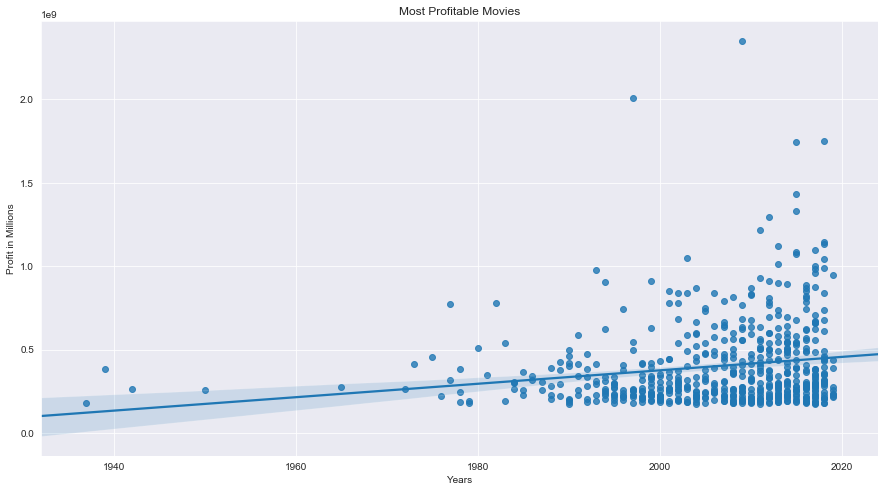

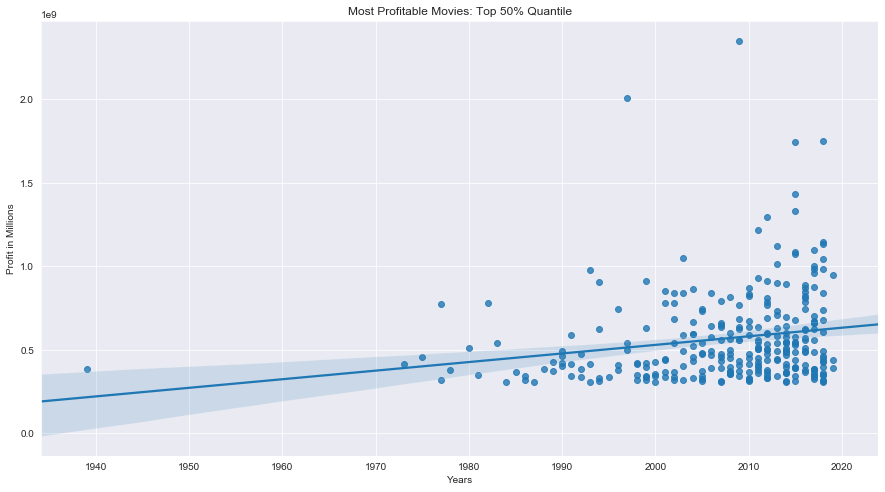

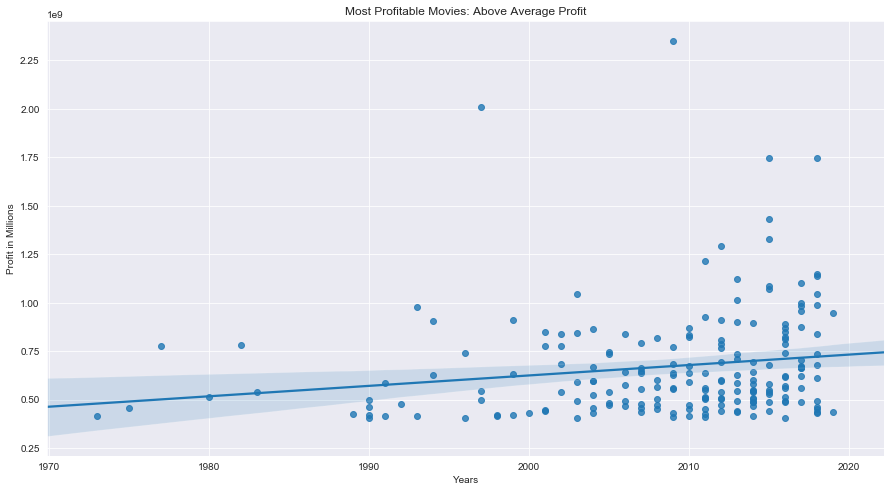

In [50]:
plot_years_df(top_movies, 'Most Profitable Movies')
plot_years_df(top_50_percent_profit, 'Most Profitable Movies: Top 50% Quantile')
plot_years_df(above_mean_profit, 'Most Profitable Movies: Above Average Profit')